In [1]:
!pip install pyarrow

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [4]:
import pickle

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [6]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    
    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime    
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df    

In [7]:
df_train = read_dataframe("/workspaces/mlops-zoomcamp2025/01-intro/data/yellow_tripdata_2023-01.parquet")
df_val = read_dataframe("/workspaces/mlops-zoomcamp2025/01-intro/data/yellow_tripdata_2023-02.parquet")

In [9]:
df_train["PU_DO"] = df_train["PULocationID"] + " " + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + " " + df_val["DOLocationID"]

In [14]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [15]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.198308362934203

In [17]:
with open("/workspaces/mlops-zoomcamp2025/01-intro/models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.legend(*args, **kwargs)>

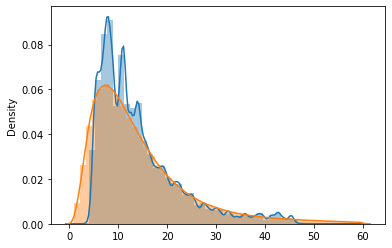

In [18]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend